In [1]:
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
class _NonLocalBlockND(nn.Module):
    def __init__(self, in_channels, inter_channels=None, dimension=3, sub_sample=True, bn_layer=True):
        super(_NonLocalBlockND, self).__init__()

        assert dimension in [1, 2, 3]

        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        if dimension == 3:
            conv_nd = nn.Conv3d
            max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))
            bn = nn.BatchNorm3d
        elif dimension == 2:
            conv_nd = nn.Conv2d
            max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
            bn = nn.BatchNorm2d
        else:
            conv_nd = nn.Conv1d
            max_pool_layer = nn.MaxPool1d(kernel_size=(2))
            bn = nn.BatchNorm1d

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''

        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z

In [3]:
class NONLocalBlock1D(_NonLocalBlockND):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NONLocalBlock1D, self).__init__(in_channels,
                                              inter_channels=inter_channels,
                                              dimension=1, sub_sample=sub_sample,
                                              bn_layer=bn_layer)


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True)

        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        # x: (seq_length, N) where N is batch size

        embedding = self.dropout(x)
        # embedding shape: (seq_length, N, embedding_size)

        encoder_states, (hidden, cell) = self.rnn(embedding)
        # outputs shape: (seq_length, N, hidden_size)

        # Use forward, backward cells and hidden through a linear layer
        # so that it can be input to the decoder which is not bidirectional
        # Also using index slicing ([idx:idx+1]) to keep the dimension
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_cell(torch.cat((cell[0:1], cell[1:2]), dim=2))

        return encoder_states, hidden, cell

In [5]:
class Decoder(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(hidden_size * 2, hidden_size, num_layers)
        self.conv1 = nn.Conv1d(20, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv1d(64, 20, kernel_size=3, stride=1, padding=1, bias=False)
        self.linear = nn.Linear(hidden_size * 3, hidden_size * 2)

        self.attention = NONLocalBlock1D(in_channels=64)
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()

    def forward(self, encoder_states, hidden, cell):

        sequence_length = encoder_states.shape[0]
        h_reshaped = hidden.repeat(sequence_length, 1, 1)
        # h_reshaped: (seq_length, N, hidden_size*2)

        attention_input = torch.cat((h_reshaped, encoder_states), dim=2)
        attention_input = attention_input.transpose(0,1)
        attention_input = self.conv1(attention_input)
        context_vector = self.attention(attention_input)
        context_vector = self.conv2(context_vector)
        context_vector = self.linear(context_vector)
        context_vector = context_vector.transpose(0,1)

        rnn_input = context_vector
        # rnn_input: (1, N, hidden_size*2 + embedding_size)

        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # outputs shape: (1, N, hidden_size)

        predictions = self.fc(outputs).squeeze(0)
        # predictions: (N, hidden_size)

        return predictions, hidden, cell

In [6]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(20*22, 1)

    def forward(self, source, teacher_force_ratio=0.5):
        source = source.transpose(0,1)
        batch_size = source.shape[1]
        target_len = source.shape[0]
        target_vocab_size = 22

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_states, hidden, cell = self.encoder(source)

        # At every time step use encoder_states and update hidden, cell
        output, hidden, cell = self.decoder(encoder_states, hidden, cell)

        # Store prediction for current time step
        outputs = output
            
        outputs = outputs.transpose(0,1)
        outputs = self.flatten(outputs)
        outputs = self.final_layer(outputs)

        return outputs

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder_net = Encoder(
    input_size=22,  
    hidden_size=32, 
    num_layers=1, 
    p=0
).to(device)

decoder_net = Decoder(
    input_size=22,
    hidden_size=32,
    output_size=22,
    num_layers=1,
    p=0,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)

In [8]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x,x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.0175],
        [-0.0221],
        [-0.0195],
        [-0.0187],
        [-0.0200]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
df_for_training.shape

(11524, 22)

In [14]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [15]:
trainX=[]
trainY=[]

In [16]:
n_future=1
n_past=20

In [17]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [18]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [19]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [20]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [21]:
data,label=random_shuffle(trainX,trainY)

In [22]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.07843485474586487
Epoch: 1 Loss: 0.0409960076212883
Epoch: 2 Loss: 0.07923933863639832
Epoch: 3 Loss: 0.08169925212860107
Epoch: 4 Loss: 0.139016792178154
Epoch: 5 Loss: 0.07649896293878555
Epoch: 6 Loss: 0.055038586258888245
Epoch: 7 Loss: 0.025862334296107292
Epoch: 8 Loss: 0.08996948599815369
Epoch: 9 Loss: 0.04825165495276451
Epoch: 10 Loss: 0.04389794170856476
Epoch: 11 Loss: 0.055965352803468704
Epoch: 12 Loss: 0.033644091337919235
Epoch: 13 Loss: 0.0955893024802208
Epoch: 14 Loss: 0.013026561588048935
Epoch: 15 Loss: 0.030266081914305687
Epoch: 16 Loss: 0.023088937625288963
Epoch: 17 Loss: 0.039750710129737854
Epoch: 18 Loss: 0.06093733757734299
Epoch: 19 Loss: 0.0230533629655838
Epoch: 20 Loss: 0.029674235731363297
Epoch: 21 Loss: 0.019734665751457214
Epoch: 22 Loss: 0.060994766652584076
Epoch: 23 Loss: 0.03107472136616707
Epoch: 24 Loss: 0.07424607127904892
Epoch: 25 Loss: 0.016928397119045258
Epoch: 26 Loss: 0.04568060487508774
Epoch: 27 Loss: 0.0512480288743

Epoch: 221 Loss: 0.02036573737859726
Epoch: 222 Loss: 0.015920856967568398
Epoch: 223 Loss: 0.010436885058879852
Epoch: 224 Loss: 0.055205799639225006
Epoch: 225 Loss: 0.013538047671318054
Epoch: 226 Loss: 0.024181190878152847
Epoch: 227 Loss: 0.038905270397663116
Epoch: 228 Loss: 0.017570102587342262
Epoch: 229 Loss: 0.017919553443789482
Epoch: 230 Loss: 0.037777096033096313
Epoch: 231 Loss: 0.025462131947278976
Epoch: 232 Loss: 0.0044215377420187
Epoch: 233 Loss: 0.030928699299693108
Epoch: 234 Loss: 0.012435849756002426
Epoch: 235 Loss: 0.024808943271636963
Epoch: 236 Loss: 0.005111689679324627
Epoch: 237 Loss: 0.006479667499661446
Epoch: 238 Loss: 0.007991623133420944
Epoch: 239 Loss: 0.009815129451453686
Epoch: 240 Loss: 0.003946597687900066
Epoch: 241 Loss: 0.021865107119083405
Epoch: 242 Loss: 0.011379910632967949
Epoch: 243 Loss: 0.016902592033147812
Epoch: 244 Loss: 0.03375595062971115
Epoch: 245 Loss: 0.01622704416513443
Epoch: 246 Loss: 0.011038428172469139
Epoch: 247 Loss: 

Epoch: 438 Loss: 0.00871416088193655
Epoch: 439 Loss: 0.014271287247538567
Epoch: 440 Loss: 0.0035530980676412582
Epoch: 441 Loss: 0.006346357055008411
Epoch: 442 Loss: 0.02299400418996811
Epoch: 443 Loss: 0.010523626580834389
Epoch: 444 Loss: 0.029012251645326614
Epoch: 445 Loss: 0.008269582875072956
Epoch: 446 Loss: 0.006146539002656937
Epoch: 447 Loss: 0.011136883869767189
Epoch: 448 Loss: 0.022510139271616936
Epoch: 449 Loss: 0.01472383737564087
Epoch: 450 Loss: 0.024879993870854378
Epoch: 451 Loss: 0.012014424428343773
Epoch: 452 Loss: 0.010490819811820984
Epoch: 453 Loss: 0.017926303669810295
Epoch: 454 Loss: 0.01481914333999157
Epoch: 455 Loss: 0.013888725079596043
Epoch: 456 Loss: 0.025835689157247543
Epoch: 457 Loss: 0.01988704316318035
Epoch: 458 Loss: 0.014790989458560944
Epoch: 459 Loss: 0.007518738508224487
Epoch: 460 Loss: 0.011944890022277832
Epoch: 461 Loss: 0.008130492642521858
Epoch: 462 Loss: 0.003132305108010769
Epoch: 463 Loss: 0.011303389444947243
Epoch: 464 Loss:

Epoch: 655 Loss: 0.025332001969218254
Epoch: 656 Loss: 0.009908558800816536
Epoch: 657 Loss: 0.007858180440962315
Epoch: 658 Loss: 0.013467282056808472
Epoch: 659 Loss: 0.0026077935472130775
Epoch: 660 Loss: 0.008391618728637695
Epoch: 661 Loss: 0.010834853164851665
Epoch: 662 Loss: 0.011661870405077934
Epoch: 663 Loss: 0.011089302599430084
Epoch: 664 Loss: 0.00961629580706358
Epoch: 665 Loss: 0.006251038983464241
Epoch: 666 Loss: 0.006668930873274803
Epoch: 667 Loss: 0.006642927415668964
Epoch: 668 Loss: 0.006331987679004669
Epoch: 669 Loss: 0.011218748986721039
Epoch: 670 Loss: 0.0069664884358644485
Epoch: 671 Loss: 0.007285170257091522
Epoch: 672 Loss: 0.003619804047048092
Epoch: 673 Loss: 0.012682972475886345
Epoch: 674 Loss: 0.017800316214561462
Epoch: 675 Loss: 0.01375296339392662
Epoch: 676 Loss: 0.009100012481212616
Epoch: 677 Loss: 0.006628473289310932
Epoch: 678 Loss: 0.004301704466342926
Epoch: 679 Loss: 0.009582269936800003
Epoch: 680 Loss: 0.026778921484947205
Epoch: 681 L

Epoch: 872 Loss: 0.018814941868185997
Epoch: 873 Loss: 0.002288026735186577
Epoch: 874 Loss: 0.009102022275328636
Epoch: 875 Loss: 0.002520347246900201
Epoch: 876 Loss: 0.007882006466388702
Epoch: 877 Loss: 0.012481607496738434
Epoch: 878 Loss: 0.007263975217938423
Epoch: 879 Loss: 0.0050544217228889465
Epoch: 880 Loss: 0.009329932741820812
Epoch: 881 Loss: 0.011716088280081749
Epoch: 882 Loss: 0.013171224854886532
Epoch: 883 Loss: 0.004358060657978058
Epoch: 884 Loss: 0.015548475086688995
Epoch: 885 Loss: 0.009228517301380634
Epoch: 886 Loss: 0.0060958825051784515
Epoch: 887 Loss: 0.013692079111933708
Epoch: 888 Loss: 0.0050765154883265495
Epoch: 889 Loss: 0.007156966254115105
Epoch: 890 Loss: 0.0039010588079690933
Epoch: 891 Loss: 0.006893065292388201
Epoch: 892 Loss: 0.00485333614051342
Epoch: 893 Loss: 0.009990302845835686
Epoch: 894 Loss: 0.007138291373848915
Epoch: 895 Loss: 0.008603706024587154
Epoch: 896 Loss: 0.013023605570197105
Epoch: 897 Loss: 0.01075245812535286
Epoch: 898

In [25]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [27]:
predictions = np.array(predictions)

In [28]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [29]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

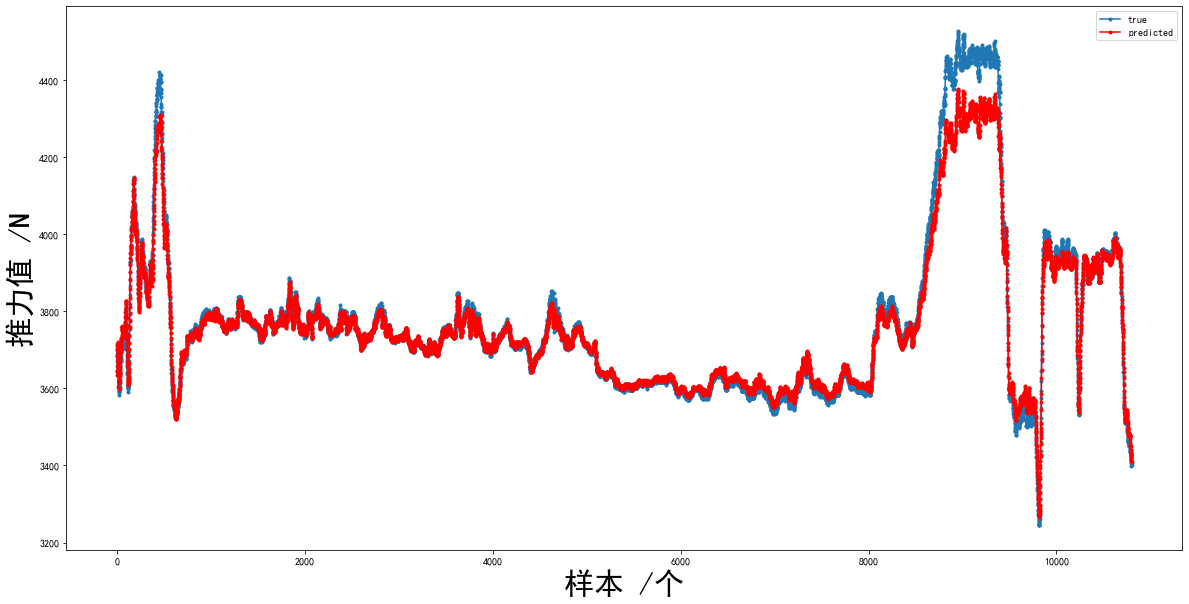

In [30]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();